In [1]:
# -+- coding:utf-8 -*-
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(use_idf=True, min_df=0.02, stop_words=[],token_pattern=u'(?u)\\b\\w+\\b')
data_path = "./data/news_ma/"
    
#分かち書き文章を取得
with open("./data/news_ma/news_wakati.txt", 'r') as rfile:
    lines = rfile.readlines()
    docs = np.array([l.replace("\n", "") for l in lines])
    #["文書aの分かち書き", "文書bの分かち書き", ...]

#tfidfベクトルの生成
tfidf_vecs = vectorizer.fit_transform(docs)
print(tfidf_vecs.shape) #(文書数, 語彙数)
print(vectorizer.vocabulary_) #語彙一覧

(1770, 1507)
{'dvd': 84, 'エンター': 278, 'られる': 249, '女': 769, '目': 1184, 'する': 178, '真実': 1192, '孤独': 789, '2006年': 25, '連載': 1410, 'れる': 250, '初': 619, 'サスペンス': 313, '2010年': 28, '出演': 611, '化': 649, '2011年': 30, '4月': 61, '映画化': 986, '劇場公開': 630, '過ぎる': 1419, 'ブルーレイ': 397, 'なる': 214, '発売': 1171, 'ある': 120, '男': 1160, '彼女': 845, '妻': 778, '子供': 787, 'こと': 161, '知る': 1195, '見る': 1318, '行く': 1300, '的': 1178, '続ける': 1249, '暮らす': 1000, '相手': 1190, '演じる': 1111, '子': 786, '彼': 843, 'それ': 185, '待つ': 847, 'くれる': 156, '信じる': 563, '身体': 1390, 'しまう': 170, 'その後': 184, '決意': 1088, '最後': 1009, 'つける': 195, 'ため': 190, '彼ら': 844, '6': 65, 'ヶ月': 453, '顔': 1484, '自分': 1279, '笑顔': 1217, '向ける': 695, '名前': 693, '変える': 737, '二人': 508, '幸せ': 829, '時間': 997, '過ごす': 1420, '着る': 1193, 'いる': 137, '場所': 729, '打つ': 912, '果たす': 1037, '後': 849, '言う': 1332, '無い': 1117, '受ける': 672, '本当': 1024, '関係': 1455, 'まま': 229, '成長': 901, '過去': 1421, 'くる': 155, '道': 1424, '気付く': 1078, '生活': 1156, '旅': 966, '出る': 605, '触れる': 1331, '

In [2]:
#プロット用に次元削減
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(2)
svd_vecs = svd.fit_transform(tfidf_vecs)
print(svd_vecs)

[[ 0.38588807 -0.05177993]
 [ 0.56464581 -0.03317373]
 [ 0.41480447 -0.14996453]
 ...
 [ 0.3785256   0.26182446]
 [ 0.29399034  0.08209401]
 [ 0.31528625  0.18945588]]


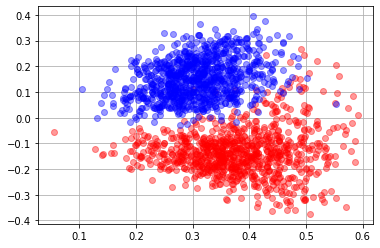

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
#とりあえず可視化
color_ctr = "red" #赤：映画記事 青：スポーツ記事
for x in range(len(svd_vecs)):
    if x >= 870:
        color_ctr = "blue"
    plt.plot(svd_vecs[x][0], svd_vecs[x][1], marker='o', linestyle='none', alpha=0.4, color=color_ctr)

plt.grid(True)
plt.show()

In [7]:
#ロジスティック回帰をやってみる
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import cross_val_score
#データのラベルを生成
label = ["movie" if i < 870 else "sports" for i in range(len(docs))]
#学習
clf = LR(solver='lbfgs')

# 交差検証
scores = cross_val_score(clf, tfidf_vecs, label, cv=5)
# 各分割におけるスコア
print('交差検証の各回の精度: {0}'.format(scores))
print('精度の平均: {0}'.format(np.mean(scores)))

交差検証の各回の精度: [0.99717514 1.         0.99717514 1.         0.99717514]
精度の平均: 0.9983050847457626


In [78]:
#曲線をプロットしてみる
import math

#学習用と訓練用にデータの分割
X_train, X_test, y_train, y_test = train_test_split(tfidf_vecs, label, test_size=0.3)
lr = LR(solver='lbfgs')
lr.fit(X_train, y_train)

#print("訓練データの正解率：" ,lr.score(X_train, y_train))
print("テストデータの正解率：", lr.score(X_test, y_test))
#print (lr.predict(X_test)) #テストデータを入れて分類してみた結果
print ("バイアス：" ,lr.intercept_)
print ("重み：", lr.coef_[0])

テストデータの正解率： 1.0
バイアス： [0.97005258]
重み： [ 0.13772275 -0.22574424 -0.25822901 ... -0.52789483  0.19662407
  0.23402751]


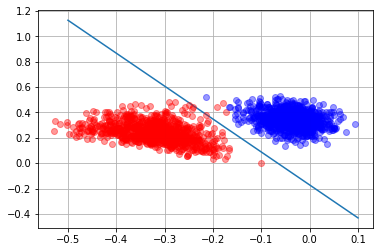

In [77]:
#境界線関数
def logistic(t, w):
    return (-w[0] * t - lr.intercept_[0])/w[1]

#ベクトルの連結
from scipy import sparse
#tfidf末尾に重みベクトルをつけて次元削減
plt_vecs = svd.fit_transform(sparse.vstack((tfidf_vecs, lr.coef_)))
w_vecs = plt_vecs[-1]

#ロジスティック関数の描画
t = np.linspace(-0.5,0.1,50)
y = np.array([logistic(ele, w_vecs) for ele in t])
plt.plot(t,y)
plt.grid(True)

#tfidfベクトルのプロット
color_ctr = "red" #赤：映画記事 青：スポーツ記事
for x in range(len(plt_vecs)-1):
    if x >= 870:
        color_ctr = "blue"
    plt.plot(svd_vecs[x][0], svd_vecs[x][1], marker='o', linestyle='none', alpha=0.4, color=color_ctr)